绘制 InferTuner 相较 DS2 和 ContTune 的 GPU 节省情况

In [117]:
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib import pyplot as plt

from pathlib import Path
from loguru import logger

In [118]:
csv_file_path = Path("../data/submit_job_Falcon3-7B-Instruct_1000ms/comparison_results.csv")
data = pd.read_csv(csv_file_path)

In [119]:
# 提取数据
scenarios = data['Scenario']
target_throughput = data['Target_Throughput(req/s)']
ds2_cost = data['DS2_cost']
contune_cost = data['ContTune_cost']
infertuner_cost = data['InferTuner_cost']
infertuner_b = data['InferTuner_b']

# 标记DS2无解的场景
ds2_unsolvable = ds2_cost.isna()

# 绘制GPU成本对比图
x_pos = np.arange(len(scenarios))
width = 0.25

# 为DS2无解的场景设置特殊标记
ds2_cost_plot = ds2_cost.copy()
ds2_cost_plot[ds2_unsolvable] = max(contune_cost.max(), infertuner_cost.max()) * 1  # 设置为比最大值稍高的值

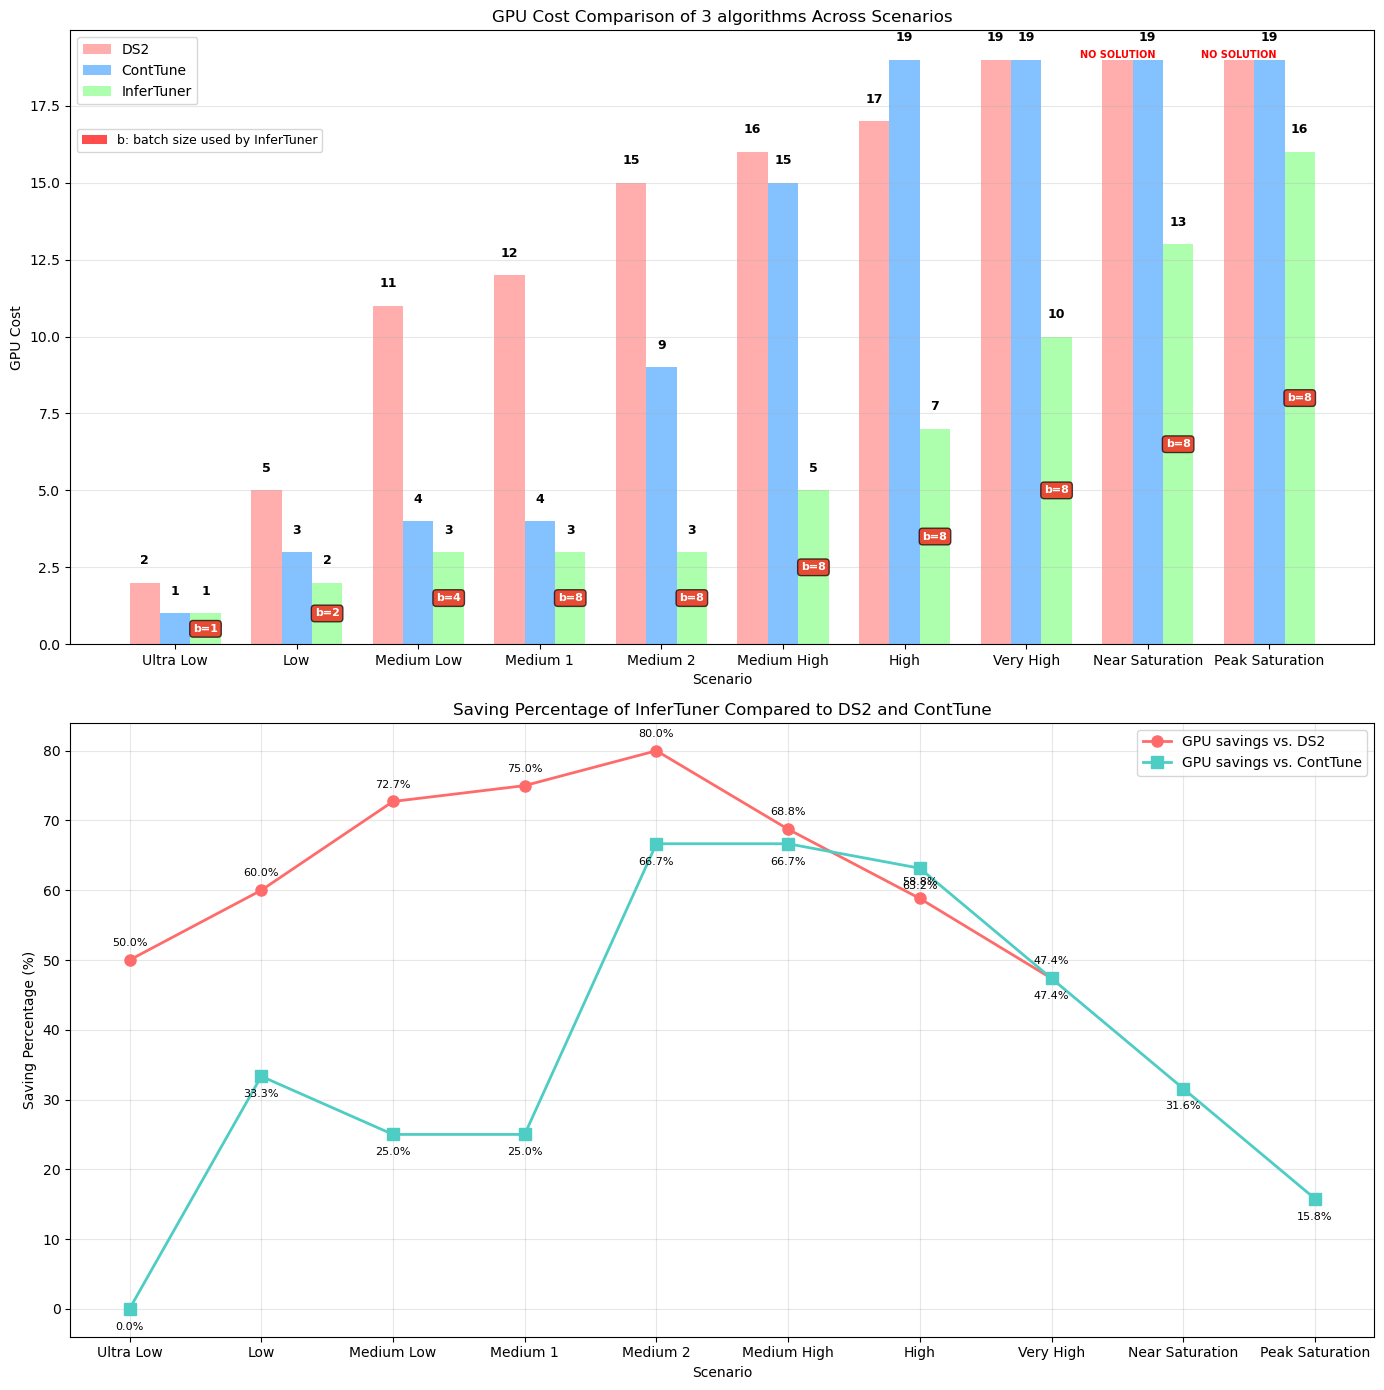

GPU节省统计摘要:
Ultra Low:
  DS2成本: 2.0, ContTune成本: 1, InferTuner成本: 1
  相比DS2节省: 50.0%, 相比ContTune节省: 0.0%
------------------------------
Low:
  DS2成本: 5.0, ContTune成本: 3, InferTuner成本: 2
  相比DS2节省: 60.0%, 相比ContTune节省: 33.3%
------------------------------
Medium Low:
  DS2成本: 11.0, ContTune成本: 4, InferTuner成本: 3
  相比DS2节省: 72.7%, 相比ContTune节省: 25.0%
------------------------------
Medium 1:
  DS2成本: 12.0, ContTune成本: 4, InferTuner成本: 3
  相比DS2节省: 75.0%, 相比ContTune节省: 25.0%
------------------------------
Medium 2:
  DS2成本: 15.0, ContTune成本: 9, InferTuner成本: 3
  相比DS2节省: 80.0%, 相比ContTune节省: 66.7%
------------------------------
Medium High:
  DS2成本: 16.0, ContTune成本: 15, InferTuner成本: 5
  相比DS2节省: 68.8%, 相比ContTune节省: 66.7%
------------------------------
High:
  DS2成本: 17.0, ContTune成本: 19, InferTuner成本: 7
  相比DS2节省: 58.8%, 相比ContTune节省: 63.2%
------------------------------
Very High:
  DS2成本: 19.0, ContTune成本: 19, InferTuner成本: 10
  相比DS2节省: 47.4%, 相比ContTune节省: 47.4%
---------------------

In [120]:
# 创建图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

bars1 = ax1.bar(x_pos - width, ds2_cost_plot, width, label='DS2', alpha=0.8, color='#FF9999')
bars2 = ax1.bar(x_pos, contune_cost, width, label='ContTune', alpha=0.8, color='#66B2FF')
bars3 = ax1.bar(x_pos + width, infertuner_cost, width, label='InferTuner', alpha=0.8, color='#99FF99')

# 在每个柱子上标注GPU数量
for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
    # DS2柱子标注
    if not ds2_unsolvable[i]:
        ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.5,
                 f'{int(ds2_cost[i])}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # ContTune柱子标注
    ax1.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
             f'{int(contune_cost[i])}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # InferTuner柱子标注（GPU数量和batch size）
    ax1.text(bar3.get_x() + bar3.get_width()/2, bar3.get_height() + 0.5,
             f'{int(infertuner_cost[i])}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 在InferTuner柱子内部标注batch size
    if bar3.get_height() > 0:
        ax1.text(bar3.get_x() + bar3.get_width()/2, bar3.get_height()/2,
                 f'b={int(infertuner_b[i])}', ha='center', va='center',
                 fontweight='bold', fontsize=8, color='white',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7))

# 标记DS2无解的场景
for i, unsolvable in enumerate(ds2_unsolvable):
    if unsolvable:
        ax1.text(x_pos[i] - width, ds2_cost_plot[i] * 1.0, 'NO SOLUTION',
                 ha='center', va='bottom', fontweight='bold', color='red', fontsize=7)

ax1.set_xlabel('Scenario')
ax1.set_ylabel('GPU Cost')
ax1.set_title('GPU Cost Comparison of 3 algorithms Across Scenarios')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenarios, ha='center')
ax1.legend()
ax1.grid(True, axis='y', alpha=0.3)

# 获取原有的算法图例
legend1 = ax1.legend(loc='upper left', fontsize=10)

# 添加batch size说明的图例
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='b: batch size used by InferTuner')
]
# 将batch size图例放在左上角算法图例的下方
legend2 = ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.0, 0.85),
                     fontsize=9, framealpha=0.8)

# 将第一个图例添加回axes
ax1.add_artist(legend1)

# 绘制节省比例图
savings_vs_ds2 = []
savings_vs_contune = []

for i in range(len(scenarios)):
    if not ds2_unsolvable[i]:
        savings_vs_ds2.append((ds2_cost[i] - infertuner_cost[i]) / ds2_cost[i] * 100)
    else:
        savings_vs_ds2.append(np.nan)

    savings_vs_contune.append((contune_cost[i] - infertuner_cost[i]) / contune_cost[i] * 100)

ax2.plot(scenarios, savings_vs_ds2, 'o-', label='GPU savings vs. DS2', linewidth=2, markersize=8, color='#FF6B6B')
ax2.plot(scenarios, savings_vs_contune, 's-', label='GPU savings vs. ContTune', linewidth=2, markersize=8, color='#4ECDC4')

ax2.set_xlabel('Scenario')
ax2.set_ylabel('Saving Percentage (%)')
ax2.set_title('Saving Percentage of InferTuner Compared to DS2 and ContTune')
ax2.set_xticks(range(len(scenarios)))
ax2.set_xticklabels(scenarios, ha='center')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 添加数值标签
for i, (save_ds2, save_contune) in enumerate(zip(savings_vs_ds2, savings_vs_contune)):
    if not np.isnan(save_ds2):
        ax2.annotate(f'{save_ds2:.1f}%', (i, save_ds2), textcoords="offset points",
                     xytext=(0,10), ha='center', fontsize=8)
    ax2.annotate(f'{save_contune:.1f}%', (i, save_contune), textcoords="offset points",
                 xytext=(0,-15), ha='center', fontsize=8)

# 调整布局
plt.tight_layout()

# 添加总体标题
# fig.suptitle('GPU Saving Efficiency of InferTuner', fontsize=16, fontweight='bold')

# 保存图表
plt.savefig('../figs/infertuner_gpu_savings.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印统计摘要
print("GPU节省统计摘要:")
print("=" * 50)
for i, scenario in enumerate(scenarios):
    if not ds2_unsolvable[i]:
        print(f"{scenario}:")
        print(f"  DS2成本: {ds2_cost[i]}, ContTune成本: {contune_cost[i]}, InferTuner成本: {infertuner_cost[i]}")
        print(f"  相比DS2节省: {savings_vs_ds2[i]:.1f}%, 相比ContTune节省: {savings_vs_contune[i]:.1f}%")
        print("-" * 30)
    else:
        print(f"{scenario}:")
        print(f"  DS2: 无解, ContTune成本: {contune_cost[i]}, InferTuner成本: {infertuner_cost[i]}")
        print(f"  相比ContTune节省: {savings_vs_contune[i]:.1f}%")
        print("-" * 30)